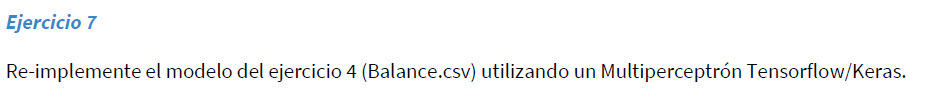

In [1]:
# configuración para notebook con instalación LOCAL
FUENTES_DIR  = '../../Datos-Fuentes/Fuentes/'     # carpeta donde se encuentran archivos .py auxiliares
DATOS_DIR    = '../../Datos-Fuentes/Datos/'      # carpeta donde se encuentran los datasets
MODELOS_DIR  = '../Modelos/'    # carpeta donde se encuentran los modelos
ARCHIVOs_DIR = '../Archivos/'   # carpeta recuperar o copiar archivos

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

   Balance  LeftWeight  LeftDist  RightWeight  RightDist
0        B           1         1            1          1
1        R           1         1            1          2
2        R           1         1            1          3
3        R           1         1            1          4
4        R           1         1            1          5
5        R           1         1            2          1
6        R           1         1            2          2
7        R           1         1            2          3
8        R           1         1            2          4
9        R           1         1            2          5
10       R           1         1            3          1
11       R           1         1            3          2


<Axes: >

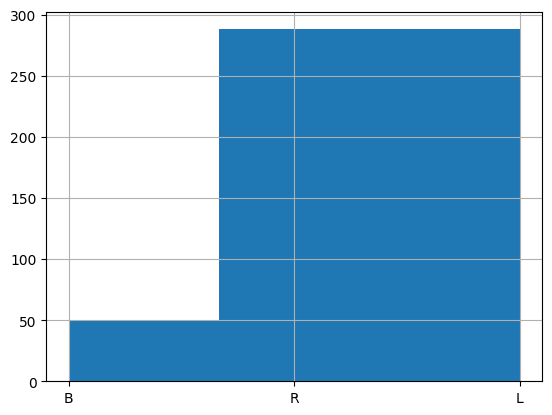

In [8]:
import pandas as pd
import chardet           # para detectar la codificación de texto en archivos
import numpy as np

from sklearn import preprocessing, model_selection, metrics

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras import optimizers

from matplotlib import pyplot as plt
import plotly.express as px

nombre_archivo = DATOS_DIR + 'Balance.csv' # archivo de hojas

#-- detectando la codificación de caracteres usada ----
with open(nombre_archivo, 'rb') as f:
    result = chardet.detect(f.read())  # or readline if the file is large

# recupera el archivo en un objeto dataframe de pandas utilizando la codificación detectada
df = pd.read_csv(nombre_archivo, encoding=result['encoding'])

# visualiza el dataframe

# Para hacer una inspección rápida de los datos
print(df.head(12))
#display(df)

#print(df.describe())
df['Balance'].hist(bins=3)

## Seleccion de atributos y target

In [14]:
# %% separa atributos y clases
X_raw = np.array(df.iloc[:, 1:])
Y_raw = np.array(df['Balance'])

# Binarizador para convertir el nombre de la clase en one hot encoding
binarizer = preprocessing.LabelBinarizer()

# Binariza cada clase como una combinación de un 1 y 0s
Y_raw = binarizer.fit_transform(Y_raw)
print('Las clases del dataset son :', binarizer.classes_)

# Escala los atributos de los ejemplo
scaler = preprocessing.StandardScaler()
#scaler = preprocessing.MinMaxScaler()
X_raw  = scaler.fit_transform( X_raw )

# %% Separa ejemplos para enternamiento y testeo
TEST_SIZE = 0.2 # proporcion entre testeo entre entrenamiento y testeo
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X_raw, Y_raw, test_size=TEST_SIZE)#, random_state=42)

print('\nDatos de Entrenamiento: %d   Datos de Testeo: %d' % (len(Y_train), len(Y_test) ))


Las clases del dataset son : ['B' 'L' 'R']

Datos de Entrenamiento: 500   Datos de Testeo: 125


## Definicion de funciones para metricas

In [15]:
# calcula las metricas precision, recall, f1-score y accuracy a partir de la matriz de confusion
# retorna tupla: ( precision, recall, f1_score, accuracy )
def calcular_metricas(conf_mat):
    precision = np.zeros(conf_mat.shape[0])
    for i in range(0, len(conf_mat)):
        precision[i] = conf_mat[i][i]/sum(conf_mat.T[i])

    recall = np.zeros(conf_mat.shape[0])
    for i in range(0, len(conf_mat)):
        recall[i] = conf_mat[i][i]/sum(conf_mat[i])

    f1_score = 2* (precision*recall) /(precision+recall)

    accuracy =  0
    for i in range(0, len(conf_mat)):
        accuracy+=conf_mat[i][i]
    accuracy/= conf_mat.sum()

    return ( precision, recall, f1_score, accuracy )

# el parámetro metricas es una tupla ( precision, recall, f1_score, accuracy )
def imprimir_metricas( metricas ):
    (precision, recall, f1_score, accuracy) = metricas
    print('\n clase   precision    recall    f1-score')
    for i in range(0, len(precision)):
        print('%5d %10.2f %10.2f %10.2f' % (i, precision[i], recall[i], f1_score[i]))
    print('\naccuracy: %6.2f\n' % accuracy)


## Entrenamiento

In [29]:
ENTRADAS = X_train.shape[1]
OCULTAS = 4
SALIDAS  = Y_train.shape[1]
ACTIVACION = 'relu'

#OPTIMIZADOR = 'sgd'

print(X_train.shape)
print(X_test.shape)

EPOCAS = 500
TAM_LOTE = 32
ALFA = 0.005

modelo = Sequential()
modelo.add(Input(shape=(ENTRADAS,)))
modelo.add(Dense(OCULTAS, activation=ACTIVACION))
modelo.add(Dense(SALIDAS, activation='softmax'))

modelo.summary()

#optimizador = optimizers.SGD(learning_rate=ALFA)
optimizador = optimizers.Adam(learning_rate=ALFA)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
# obtiene la arquitectura para el modelo y lo compila
modelo.compile(optimizer=optimizador, loss='categorical_crossentropy', metrics = ['accuracy'])

# Entrena el modelo y guarda la historia del progreso
history = modelo.fit(x=X_train, y=Y_train, batch_size=TAM_LOTE, epochs=EPOCAS, callbacks=[early_stop], validation_split=0.2)

(500, 4)
(125, 4)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_26 (Dense)                │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 3)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35 (140.00 B)

 Trainable params: 35 (140.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2498 - loss: 1.3054 - val_accuracy: 0.3100 - val_loss: 1.1739
Epoch 2/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3480 - loss: 1.1126 - val_accuracy: 0.4500 - val_loss: 1.0123
Epoch 3/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4822 - loss: 0.9846 - val_accuracy: 0.5800 - val_loss: 0.9080
Epoch 4/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6595 - loss: 0.8700 - val_accuracy: 0.6500 - val_loss: 0.8366
Epoch 5/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6879 - loss: 0.8394 - val_accuracy: 0.7000 - val_loss: 0.7765
Epoch 6/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7844 - loss: 0.7277 - val_accuracy: 0.7400 - val_loss: 0.7190
Epoch 7/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8239 - loss: 0.6664 - val_accuracy: 0.8100 - val_loss: 0.6672
Epoch 8/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8363 - loss: 0.6127 - val_accuracy: 0.8400 - 

In [30]:
#  ########### Medición del entrenamiento ######################
Y_pred = modelo.predict(X_train)

# "invierte" la transformacion binaria para obtener los nombres de las clases
Y_it = binarizer.inverse_transform(Y_train)
Y_pred_it = binarizer.inverse_transform(Y_pred)

# calculo manual del accuracy
print('Efectividad: %6.2f%%' % (100*(Y_pred_it == Y_it).sum()/len(Y_it)) )

report = metrics.classification_report(Y_it, Y_pred_it)
print("Reporte SkLearn:\n%s" % report)
cm = metrics.confusion_matrix(Y_it, Y_pred_it)
print("Confusion matrix:\n%s" % cm)

#calcula métricas de forma manual
mt = calcular_metricas(cm)
imprimir_metricas(mt)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Efectividad:  98.40%
Reporte SkLearn:
              precision    recall  f1-score   support

           B       0.86      1.00      0.92        36
           L       1.00      0.98      0.99       224
           R       1.00      0.98      0.99       240

    accuracy                           0.98       500
   macro avg       0.95      0.99      0.97       500
weighted avg       0.99      0.98      0.98       500

Confusion matrix:
[[ 36   0   0]
 [  3 220   1]
 [  3   1 236]]

 clase   precision    recall    f1-score
    0       0.86       1.00       0.92
    1       1.00       0.98       0.99
    2       1.00       0.98       0.99

accuracy:   0.98

